In [19]:
import math
import numpy as np
import matplotlib.pyplot as plt
from numpy import random
from sklearn.externals.joblib import Memory
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split

path_train = './data/a9a'
path_validation = './data/a9a.t'

def load_data(file_path):  
#     读取libsvm格式数据  
    x, y = load_svmlight_file(file_path)  
    return x, y

def pre_process():
#     读取训练数据
    X_train, y_train = load_data(path_train)
    X_train = X_train.toarray()
#     读取训练数据
    X_validation, y_validation = load_data(path_validation)
    X_validation = X_validation.toarray()
#     补全稀疏矩阵
    column = np.zeros(( X_validation.shape[0]))
    X_validation = np.column_stack((X_validation, column))
    #y = W^T *X + b -> y = W_extend^T * [X,1]
    column_train = np.ones((X_train.shape[0]))
    column_validation = np.ones(( X_validation.shape[0]))
    X_train = np.column_stack((X_train, column_train))
    X_validation = np.column_stack((X_validation, column_validation))    
    return X_train, y_train, X_validation, y_validation

def get_initial_parameter(X_train):
    m, n = X_train.shape
    initial_theta = np.zeros(n)
    v_t = np.zeros(n)
    return initial_theta, v_t
    
#draw the result
def draw_plot(Loss_train, Loss_validation, name):
    plt.plot(Loss_train, label="Loss_train")
    plt.plot(Loss_validation, label="Loss_validation")
    plt.legend()
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title("Logistic regression optimized by " + name)
    plt.show()

#shuffles the array
def shuffle_array(X_train, y_train):
    randomlist = np.arange(X_train.shape[0])
    np.random.shuffle(randomlist)
    X_random = X_train[randomlist]
    y_random = y_train[randomlist]
    return X_random, y_random

#get the training instance and label in current batch
def get_batch(i, iters, X_random, y_random, batch_size, shape):
    if i == iters - 1:
        X_batch = X_random[i * batch_size: shape + 1]
        y_batch = y_random[i * batch_size: shape + 1]
    else:
        X_batch = X_random[i * batch_size: (i + 1) * batch_size]
        y_batch = y_random[i * batch_size: (i + 1) * batch_size]
    return X_batch, y_batch

#calculate the loss
def compute_loss(X, y, theta, lamda):
    preY = np.dot(X, theta)
    Loss = np.sum(np.log(1 + np.exp(- y * preY)))
    Loss = Loss / X.shape[0] + lamda / 2 * np.dot(theta, theta.T)
    return Loss

#calculate the gradient
def compute_gradient(X, y, theta, lamda):
    preY = np.dot(X, theta)
    G = np.dot(((- y) / (1 + np.exp(y * preY))), X )
    G = G / X.shape[0] + theta * lamda
    return G

def NAG():
#     Hyper parameters
    eta = 0.01
    epoch = 50
    gamma = 0.9
    lamda = 0.1
    batch_size = 3000
    
#     get initial data
    X_train, y_train, X_validation, y_validation = pre_process()
    theta, v_t = get_initial_parameter(X_train)
    num_iter = int(math.ceil(X_train.shape[0] / float(batch_size)))
    sum_iteration = epoch * num_iter
    Loss_train_his = np.zeros(sum_iteration)
    Loss_validation_his = np.zeros(sum_iteration)

#     optimize the parameter theta
    for i in range(0, epoch):
        X_random,y_random = shuffle_array(X_train, y_train)
        for iter in range(0, num_iter):
            #get the training instance and label in current batch
            X_batch, y_batch = get_batch(i, num_iter, X_random, y_random, batch_size, X_train.shape[0])
            #approximate theta in the next time step
            theta_t = theta - v_t * gamma
            #the training loss
            Loss_train_his[i * num_iter + iter] = compute_loss(X_batch, y_batch, theta, lamda)
            #the gradient of the loss function
            G = compute_gradient(X_batch, y_batch, theta_t, lamda)
            #the validation loss
            Loss_validation_his[i * num_iter + iter] = compute_loss(X_validation, y_validation, theta, lamda)
            #update the parameter theta and momentum
            v_t = v_t * gamma + G * eta
            theta = theta - v_t
    #draw the result
    draw_plot(Loss_train_his, Loss_validation_his, 'NAG')

def RMSprop():
#     Hyper parameters
    eta = 0.01
    epoch = 500
    lamda = 0.1
    gamma = 0.999
    batch_size = 3000
    epsilon = np.e ** (- 8)

#     get initial data
    X_train, y_train, X_validation, y_validation = pre_process()
    theta, v_t = get_initial_parameter(X_train)
    num_iter = int(math.ceil(X_train.shape[0] / float(batch_size)))
    sum_iteration = epoch * num_iter
    Loss_train_his = np.zeros(sum_iteration)
    Loss_validation_his = np.zeros(sum_iteration)
    G_square = 0

#     optimize the parameter theta
    for i in range(0, epoch):
        X_random,y_random = shuffle_array(X_train, y_train)
        for iter in range(0, num_iter):
            #get the training instance and label in current batch
            X_batch, y_batch = get_batch(i, num_iter, X_random, y_random, batch_size, X_train.shape[0])
            #the training loss
            Loss_train_his[i * num_iter + iter] = compute_loss(X_batch, y_batch, theta, lamda)
            #the gradient of the loss function
            G = compute_gradient(X_batch, y_batch, theta, lamda)
            #the validation loss
            Loss_validation_his[i * num_iter + iter] = compute_loss(X_validation, y_validation, theta, lamda)
            #update the parameter theta and the square of the gradient
            G_square = G_square * gamma + np.dot(G,G.T) * (1 - gamma)
            theta = theta - G * (eta / math.sqrt(G_square + epsilon))
    #draw the result
    draw_plot(Loss_train_his, Loss_validation_his, 'RMSprop')

def AdaDelta():
#     Hyper parameters
    epoch = 50
    lamda = 0.1
    gamma = 0.999
    batch_size = 3000
    epsilon = np.e ** (- 8)
    delta_t = 0.01

#     get initial data
    X_train, y_train, X_validation, y_validation = pre_process()
    theta, v_t = get_initial_parameter(X_train)
    num_iter = int(math.ceil(X_train.shape[0] / float(batch_size)))
    sum_iteration = epoch * num_iter
    Loss_train_his = np.zeros(sum_iteration)
    Loss_validation_his = np.zeros(sum_iteration)
    G_square = 0

#     optimize the parameter theta
    for i in range(0, epoch):
        X_random,y_random = shuffle_array(X_train, y_train)
        for iter in range(0, num_iter):
            #get the training instance and label in current batch
            X_batch, y_batch = get_batch(i, num_iter, X_random, y_random, batch_size, X_train.shape[0])
            #the training loss
            Loss_train_his[i * num_iter + iter] = compute_loss(X_batch, y_batch, theta, lamda)
            #the gradient of the loss function
            G = compute_gradient(X_batch, y_batch, theta, lamda)
            #the validation loss
            Loss_validation_his[i * num_iter + iter] = compute_loss(X_validation, y_validation, theta, lamda)
            #update the parameter theta and the square of the gradient
            G_square = G_square * gamma + np.dot(G,G.T) * (1 - gamma)
            delta_theta = - G * ((delta_t + epsilon) ** 0.5 / (G_square + epsilon) ** 0.5)
            theta += delta_theta
            delta_t = delta_t * gamma + (1 - gamma) * delta_theta **2 
    #draw the result
    draw_plot(Loss_train_his, Loss_validation_his, 'AdaDelta')

def Adam():
#     Hyper parameters
    eta = 0.2
    epoch = 50
    lamda = 0.1
    gamma = 0.99
    batch_size = 3000
    epsilon = np.e ** (- 8)
    beta = 0.9

#     get initial data
    X_train, y_train, X_validation, y_validation = pre_process()
    theta, v_t = get_initial_parameter(X_train)
    num_iter = int(math.ceil(X_train.shape[0] / float(batch_size)))
    sum_iteration = epoch * num_iter
    Loss_train_his = np.zeros(sum_iteration)
    Loss_validation_his = np.zeros(sum_iteration)
    G_square = 0
    m_t = 0
    alpha = 0

#     optimize the parameter theta
    for i in range(0, epoch):
        X_random,y_random = shuffle_array(X_train, y_train)
        for iter in range(0, num_iter):
            #get the training instance and label in current batch
            X_batch, y_batch = get_batch(i, num_iter, X_random, y_random, batch_size, X_train.shape[0])
            #the training loss
            Loss_train_his[i * num_iter + iter] = compute_loss(X_batch, y_batch, theta, lamda)
            #the gradient of the loss function
            G = compute_gradient(X_batch, y_batch, theta, lamda)
            #the validation loss
            Loss_validation_his[i * num_iter + iter] = compute_loss(X_validation, y_validation, theta, lamda)
            #update the parameter theta and the square of the gradient
            m_t = beta * m_t + (1 - beta) * G
            G_square = G_square * gamma + np.dot(G,G.T) * (1 - gamma)
            alpha = eta * ((1 - gamma ** (iter + 1)) / (1 - beta ** (iter + 1)))
            theta = theta - alpha * (m_t / (G_square + epsilon) ** 0.5)
    #draw the result
    draw_plot(Loss_train_his, Loss_validation_his, 'Adam')

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in divide


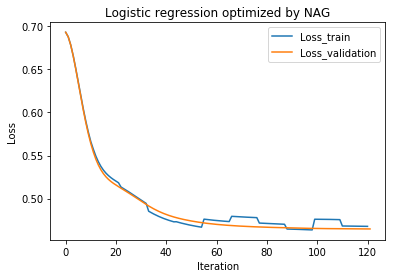

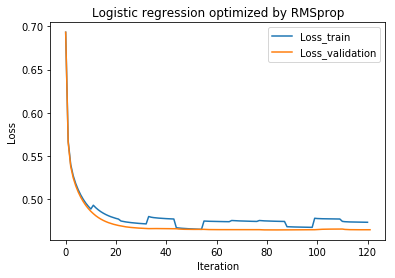

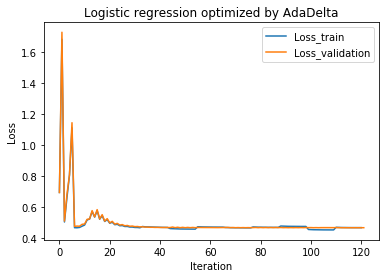

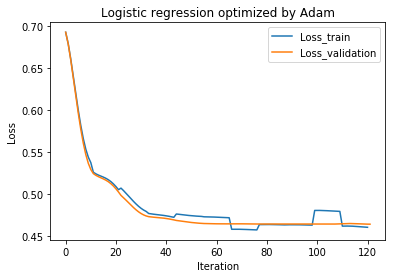

In [20]:
NAG()
RMSprop()
AdaDelta()
Adam()

Use different optmization to update the parameter $\theta$

-  Nesterov accelerated gradient(NAG)
$$g_t\leftarrow\triangledown  _{\theta}J(\theta -\gamma  \: v_{t-1})$$
$$v_t \leftarrow \gamma \: v_{t-1}+\eta g_t$$
$$\theta\leftarrow \theta - v_t$$
